In [ ]:
!wget https://sherlock-holm.es/stories/plain-text/advs.txt
!pip install np_utils

In [6]:
import re
from collections import Counter
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing import text
from keras.layers import Dot, Dense, Reshape, Embedding, Input, Dropout, BatchNormalization
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### preprocessing

In [3]:
with open('advs.txt', 'r') as file:
    advs = file.read()

advs = word_tokenize(advs.lower())

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(advs)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in advs]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 8064
Vocabulary Sample: [('the', 1), ('i', 2), ('and', 3), ('to', 4), ('of', 5), ('a', 6), ("''", 7), ('in', 8), ('that', 9), ('it', 10)]


### making skipgram pairs

In [4]:
tokenizer = Tokenizer()


tokenizer.fit_on_texts([advs])

sequences = tokenizer.texts_to_sequences([advs])[0]

vocab_size = len(tokenizer.word_index) + 1
window_size = 2
negative_samples = 4

pairs, labels = skipgrams(sequences, vocab_size, window_size=window_size, negative_samples=negative_samples)

for i in range(5):
    target_word = tokenizer.index_word[pairs[i][0]]
    context_word = tokenizer.index_word[pairs[i][1]]
    print(f"({target_word}, {context_word}), Label: {labels[i]}")

(when, she), Label: 1
(to, shocked), Label: 0
(the, promised), Label: 0
(for, half-buttoned), Label: 0
(., parish), Label: 0


### model

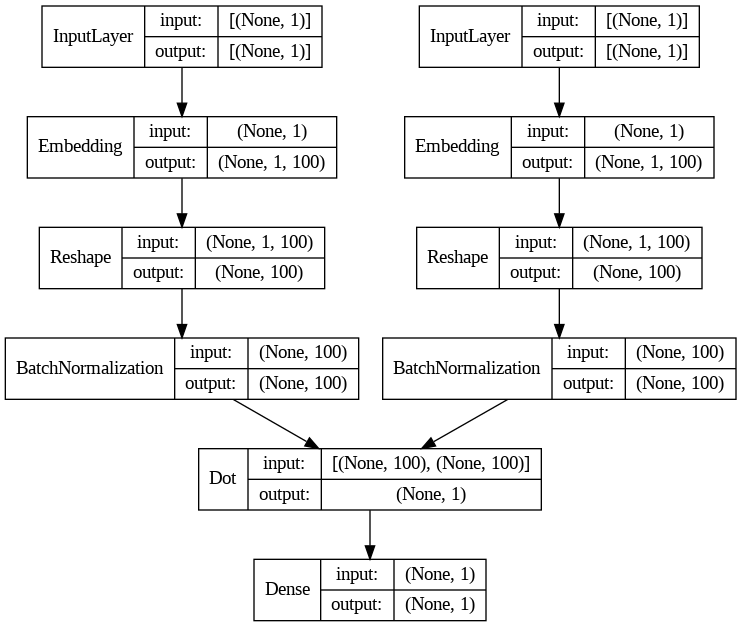

In [57]:
momentum = 0.95

word_input = Input(shape=(1,), dtype='int16')
word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_size,
                           embeddings_initializer="glorot_uniform")(word_input)

word_vector = Reshape((embed_size,))(word_embedding)

context_input = Input(shape=(1,), dtype='int16')
context_embedding = Embedding(input_dim=vocab_size, output_dim=embed_size,
                              embeddings_initializer="glorot_uniform")(context_input)

context_vector = Reshape((embed_size,))(context_embedding)


word_vector = BatchNormalization()(word_vector)
context_vector = BatchNormalization()(context_vector)

output = Dot(axes=1, normalize=False)([word_vector, context_vector])
output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=[word_input, context_input], outputs=output)
optimizer = Adam(ema_momentum=momentum)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

plot_model(model, show_shapes=True, show_layer_names=False, rankdir='TB', to_file='model.png')


### training

In [59]:
batch_size = 256


dataset = tf.data.Dataset.from_tensor_slices((pairs, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    print("Epoch:", epoch)
    loss = 0

    for batch_pairs, batch_labels in dataset:
        pair_first_elem = batch_pairs[:, 0]
        pair_second_elem = batch_pairs[:, 1]

        X = [pair_first_elem, pair_second_elem]
        Y = batch_labels

        batch_loss = model.train_on_batch(X, Y)
        loss += batch_loss

    print("Epoch", epoch, "Loss:", loss)


Epoch: 1
Epoch 2 Loss: 1897.6435738429427
Epoch: 3
Epoch 3 Loss: 1595.004409737885
Epoch: 4
Epoch 4 Loss: 1401.1266578920186
Epoch: 5
Epoch 5 Loss: 1297.5837690606713
Epoch: 6
Epoch 6 Loss: 1235.50082039088
Epoch: 7
Epoch 7 Loss: 1192.6601870954037
Epoch: 8
Epoch 8 Loss: 1163.0634306818247
Epoch: 9
Epoch 9 Loss: 1139.3980964832008
Epoch: 10
Epoch 10 Loss: 1121.6772661171854


In [60]:

word_embedding_layer = model.layers[2]
context_matrix = model.layers[3]


weights_rep = word_embedding_layer.get_weights()[0]
weights_context = context_matrix.get_weights()[0]
weights = weights_rep #+ weights_context , using only representation matrix due to it's better performance

weights = weights[1:]


### similarity

In [85]:
king_vector = weights[word2id['king']]
man_vector = weights[word2id['man']]
woman_vector = weights[word2id['woman']]
result_vector = king_vector - man_vector + woman_vector

queen_vector = weights[word2id['queen']]

similarity = np.dot(queen_vector, result_vector)/(norm(queen_vector)*norm(result_vector))

print("Similarity between 'queen' and 'king - man + woman' using inner product:", similarity)

Similarity between 'queen' and 'king - man + woman' using inner product: 0.77732646


## PCA

In [15]:
embeddings = weights

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)


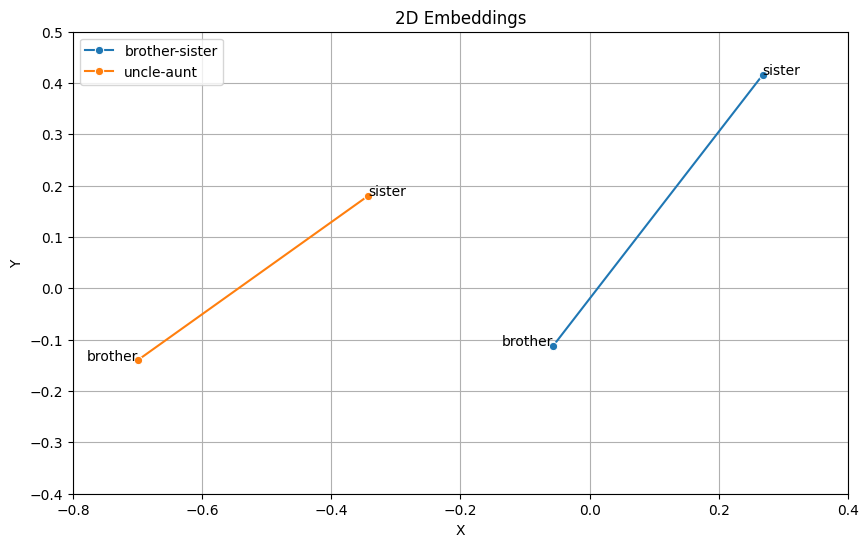

In [ ]:
brother_embedding_2d = embeddings_2d[word2id['brother']]
sister_embedding_2d = embeddings_2d[word2id['sister']]
uncle_embedding_2d = embeddings_2d[word2id['uncle']]
aunt_embedding_2d = embeddings_2d[word2id['aunt']]

difference_bro_sis = brother_embedding_2d - sister_embedding_2d
difference_unc_aun = uncle_embedding_2d - aunt_embedding_2d

plt.figure(figsize=(10, 6))

bro_sis = sns.lineplot(x=[brother_embedding_2d[0], sister_embedding_2d[0]], y=[brother_embedding_2d[1], sister_embedding_2d[1]],label ='brother-sister', marker="o")
bro_sis.set_label('brother - sister')

unc_aun = sns.lineplot(x=[uncle_embedding_2d[0], aunt_embedding_2d[0]], y=[uncle_embedding_2d[1], aunt_embedding_2d[1]],label ='uncle-aunt', marker="o")
unc_aun.set_label('uncle - aunt')

plt.xlim(-0.8, 0.4)
plt.ylim(-0.4, 0.5)

plt.grid(True)

plt.text(brother_embedding_2d[0], brother_embedding_2d[1], 'brother', horizontalalignment='right')
plt.text(sister_embedding_2d[0], sister_embedding_2d[1], 'sister', horizontalalignment='left')
plt.text(uncle_embedding_2d[0], uncle_embedding_2d[1], 'brother', horizontalalignment='right')
plt.text(aunt_embedding_2d[0], aunt_embedding_2d[1], 'sister', horizontalalignment='left')

plt.title('2D Embeddings')
plt.xlabel('X')
plt.ylabel('Y')

plt.legend()

plt.show()